# Testing Code of Medical Image

In [1]:
from shutil import copy
import os
import numpy

In [2]:
pathStr = "/Users/mingrenshen/Projects/MedicalImgAnalysis/data/DataSet9/"

In [3]:
os.listdir(pathStr)

['.DS_Store',
 'fastAITesting',
 'fastAITrain',
 'raw_patient_based',
 'DataSet9_Record.xlsx']

In [44]:
# Generate Negative Images
outputPath = pathStr + 'fastAI/nonbleeding/'
startingNegID=1
numpatients = 0
numseries = 0

with open(pathStr + 'fastAI/nonbleedingInfo.csv','w') as logFile:
    logFile.write("imgID,patientID,seriesID,label,oldfilename,newfileName \n")
    for patient in os.listdir(pathStr+"raw_patient_based/Testing/Negative Arteriograms/"):
        seriesPath = pathStr+"raw_patient_based/Testing/Negative Arteriograms/" + patient + "/"
        for series in os.listdir(seriesPath):
            imgPath = pathStr+"raw_patient_based/Testing/Negative Arteriograms/" + patient + "/" + series + "/"
            for img in os.listdir(imgPath):
                if img != '.DS_Store':
                    new_name_Path = outputPath + 'nonbleeding.' + str(startingNegID) +'.jpg'
                    copy(imgPath+img,new_name_Path)
                    logFile.write("%d,%s,%s,%s,%s,%s \n"%(startingNegID,patient,series,'nonBleeding',img,'nonbleeding.' + str(startingNegID) +'.jpg'))
                    startingNegID += 1
            numseries += 1
        numpatients += 1
# Print out Summary Information
print('Total testing Patient number is %d'%numpatients)
print('Total testing series number is %d'%numseries)
print("Total Testing negative image number is %d"%(startingNegID-1))

Total testing Patient number is 7
Total testing series number is 19
Total Testing negative image number is 297


In [46]:
# Generate Postive Images 

outputPath = pathStr + 'fastAI/bleeding/'
startingPosID=1
numpatients = 0

with open(pathStr + 'fastAI/bleedingInfo.csv','w') as logFile:
    logFile.write("imgID,patientID,label,oldfilename,newfileName \n")
    for patient in os.listdir(pathStr+"raw_patient_based/Testing/Positive Arteriograms/"):
        imgPath = pathStr+"raw_patient_based/Testing/Positive Arteriograms/" + patient + "/"
        #print(patient)
        for f in os.listdir(imgPath):
            if f != '.DS_Store':
                fs = f.split('.')
                if fs[1] == 'csv': # Postive Images Found
                    new_img_Path = outputPath + 'bleeding.' + str(startingPosID) +'.jpg'
                    #print(fs[0])
                    copy(imgPath+fs[0]+'.jpg',new_img_Path)
                    logFile.write("%d,%s,%s,%s,%s \n"%(startingPosID,patient,'Bleeding',fs[0]+'.jpg',new_img_Path))
                    startingPosID += 1
        numpatients += 1

print('Total testing Patient number is %d'%numpatients)
print("Total Testing Postive image number is %d"%(startingPosID-1))

Total testing Patient number is 19
Total Testing Postive image number is 205


# Starting Checking with the Testing Data

In [33]:
from fastai.vision import *


path = Path("/Users/mingrenshen/Projects/MedicalImgAnalysis/data/DataSet9/fastAITesting")

tfms = get_transforms(do_flip=True,
                      flip_vert=True,
                      max_lighting=0.1,
                      max_rotate=0.0, 
                      max_zoom=0.0,
                      max_warp=0.0,
                      p_affine=0.0)

# data = ImageDataBunch.from_folder(path, test='test', ds_tfms=get_transforms(), size=224)
data_test = ImageDataBunch.from_folder(path,
                                  train='train',
                                  valid='test',
                                  ds_tfms= tfms,
                                  size=224).normalize()

In [34]:
print(data_test)

ImageDataBunch;

Train: LabelList (375 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
bleeding,bleeding,bleeding,bleeding,bleeding
Path: /Users/mingrenshen/Projects/MedicalImgAnalysis/data/DataSet9/fastAITesting;

Valid: LabelList (502 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
bleeding,bleeding,bleeding,bleeding,bleeding
Path: /Users/mingrenshen/Projects/MedicalImgAnalysis/data/DataSet9/fastAITesting;

Test: None


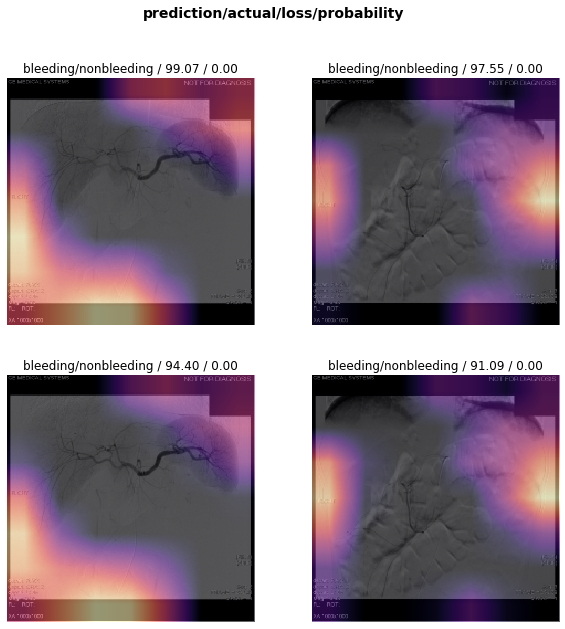

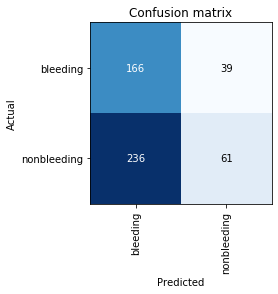

In [35]:
# Try to use the ResNet-152 model to test
# make sure we have the best performing model stage loaded
learner152 = cnn_learner(data_test, models.resnet152, metrics=accuracy)
learner152.load( "/Users/mingrenshen/Projects/MedicalImgAnalysis/resultsModelWeight/stage3/res152Run300DANotValid")
learner152.validate(data_test.valid_dl)
interp = ClassificationInterpretation.from_learner(learner152)
interp.plot_top_losses(4, figsize=(10,10))
tmpfig=interp.plot_confusion_matrix(return_fig=True)
tmpfig.savefig('confusion.png', dpi=300)

The accuracy is 0.45219123363494873 %.
ROC area is 0.46903178122690314


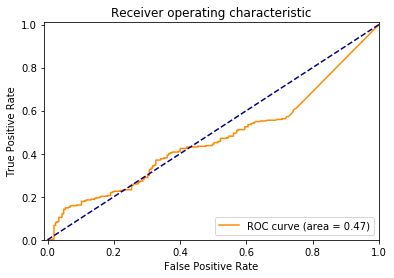

In [36]:
preds,y, loss = learner152.get_preds(ds_type=DatasetType.Valid,with_loss=True) #ds_type=DatasetType.Test,
# get accuracy
acc = accuracy(preds, y)
print('The accuracy is {0} %.'.format(acc))

# from fastai.vision import *
# from torchvision.models import *    # import *=all the models from torchvision  
# #interp = ClassificationInterpretation.from_learner(learner)
# plot_overview(interp, ['nonbleeding','bleeding'])
# plot_heatmap_overview(interp, ['nonbleeding','bleeding'])

from sklearn.metrics import roc_curve, auc
# probs from log preds
probs = np.exp(preds[:,1])
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y, probs, pos_label=1)

# Compute ROC area
roc_auc = auc(fpr, tpr)
print('ROC area is {0}'.format(roc_auc))
newfig=plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
newfig.savefig('roc.png', dpi=300)

In [37]:
# Generate Report of Performance
# print(len(data_test.valid_ds.items))
with open("performanceNeg.csv",'w') as perfcsvNeg:
    with open("performancePos.csv",'w') as perfcsvPos:
        perfcsvNeg.write("%s,%s,%s,%s\n"%("IMG",'ID',"Pred","GT"))
        perfcsvPos.write("%s,%s,%s,%s\n"%("IMG",'ID',"Pred","GT"))
        for i in range(len(data_test.valid_ds.items)):
            # Bleeding
            fnames = data_test.valid_ds.items[i].name.split('.')
            if y[i].item() == 0:
                perfcsvPos.write("%s,%s,%d,%d\n"%(data_test.valid_ds.items[i].name,'a'+fnames[1].zfill(3),np.argmax(preds[i].numpy()),y[i].item()))
            if y[i].item() == 1:
                perfcsvNeg.write("%s,%s,%d,%d\n"%(data_test.valid_ds.items[i].name,'a'+fnames[1].zfill(3),np.argmax(preds[i].numpy()),y[i].item()))

In [24]:
# Generate Report of Performance
# print(len(data_test.valid_ds.items))
with open("performance.csv",'w') as perfcsv:
    perfcsv.write("%s,%s,%s,%s\n"%("IMG",'ID',"Pred","GT"))
    for i in range(len(data_test.valid_ds.items)):
        fnames = data_test.valid_ds.items[i].name.split('.')
        perfcsv.write("%s,%s,%d,%d\n"%(data_test.valid_ds.items[i].name,fnames[1],np.argmax(preds[i].numpy()),y[i].item()))
# print(data_test.valid_ds.items[0])
# print(len(preds))
# print(len(y))

In [14]:
p=preds[100].numpy()

In [38]:
import numpy
print(p)
np.argmax(p)

NameError: name 'p' is not defined

In [18]:
y[100].item()

0

In [23]:
data_test.valid_ds.items[100].name.split('.')

['bleeding', '26', 'jpg']

# Valid as Valid

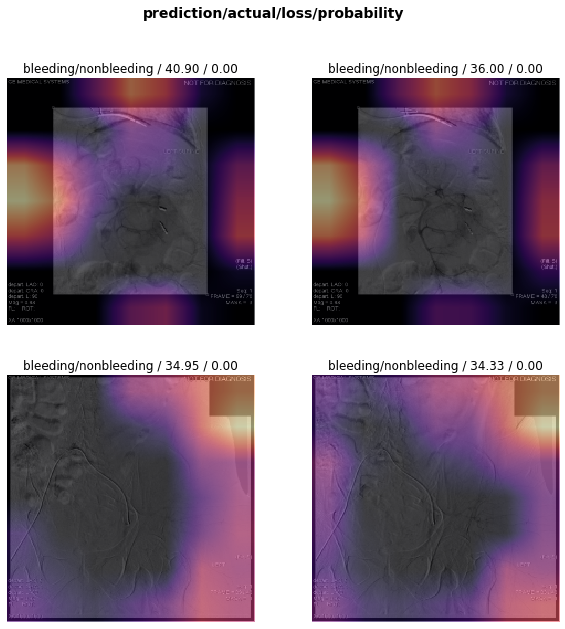

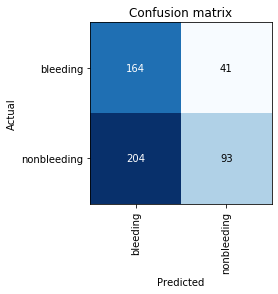

In [9]:
# Try to use the ResNet-152 model to test
# make sure we have the best performing model stage loaded
learner152 = cnn_learner(data_test, models.resnet152, metrics=accuracy)
learner152.load( "/Users/mingrenshen/Projects/MedicalImgAnalysis/resultsModelWeight/stage3/res152Run300DAValid")
learner152.validate(data_test.valid_dl)
interp = ClassificationInterpretation.from_learner(learner152)
interp.plot_top_losses(4, figsize=(10,10))
tmpfig=interp.plot_confusion_matrix(return_fig=True)
tmpfig.savefig('confusion.png', dpi=300)

The accuracy is 0.45418328046798706 %.
ROC area is 0.46171470805617143


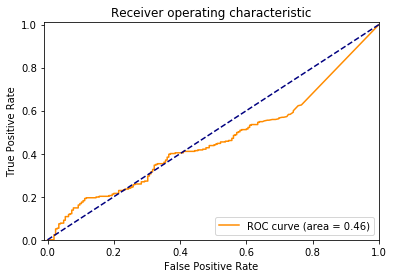

In [11]:
preds,y, loss = learner152.get_preds(ds_type=DatasetType.Valid,with_loss=True) #ds_type=DatasetType.Test,
# get accuracy
acc = accuracy(preds, y)
print('The accuracy is {0} %.'.format(acc))

# from fastai.vision import *
# from torchvision.models import *    # import *=all the models from torchvision  
# #interp = ClassificationInterpretation.from_learner(learner)
# plot_overview(interp, ['nonbleeding','bleeding'])
# plot_heatmap_overview(interp, ['nonbleeding','bleeding'])

from sklearn.metrics import roc_curve, auc
# probs from log preds
probs = np.exp(preds[:,1])
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y, probs, pos_label=1)

# Compute ROC area
roc_auc = auc(fpr, tpr)
print('ROC area is {0}'.format(roc_auc))
newfig=plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
newfig.savefig('roc.png', dpi=300)

In [13]:
print(data_test.valid_ds.items[0])

/Users/mingrenshen/Projects/MedicalImgAnalysis/data/DataSet9/fastAITesting/test/bleeding/bleeding.2.jpg


In [14]:
len(y)

502

# Test 3 adjust patients ID 1001 to Training 

Duplicate new `Dataset10` to train

In [1]:
from fastai.vision import *


path = Path("/Users/mingrenshen/Projects/MedicalImgAnalysis/data/DataSet10/fastAITesting")

tfms = get_transforms(do_flip=True,
                      flip_vert=True,
                      max_lighting=0.1,
                      max_rotate=0.0, 
                      max_zoom=0.0,
                      max_warp=0.0,
                      p_affine=0.0)

# data = ImageDataBunch.from_folder(path, test='test', ds_tfms=get_transforms(), size=224)
data_test = ImageDataBunch.from_folder(path,
                                  train='train',
                                  valid='test',
                                  ds_tfms= tfms,
                                  size=224).normalize()

In [2]:
print(data_test)

ImageDataBunch;

Train: LabelList (375 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
bleeding,bleeding,bleeding,bleeding,bleeding
Path: /Users/mingrenshen/Projects/MedicalImgAnalysis/data/DataSet10/fastAITesting;

Valid: LabelList (406 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
bleeding,bleeding,bleeding,bleeding,bleeding
Path: /Users/mingrenshen/Projects/MedicalImgAnalysis/data/DataSet10/fastAITesting;

Test: None


The accuracy is 0.5812807679176331 %.
ROC area is 0.5715325809974517


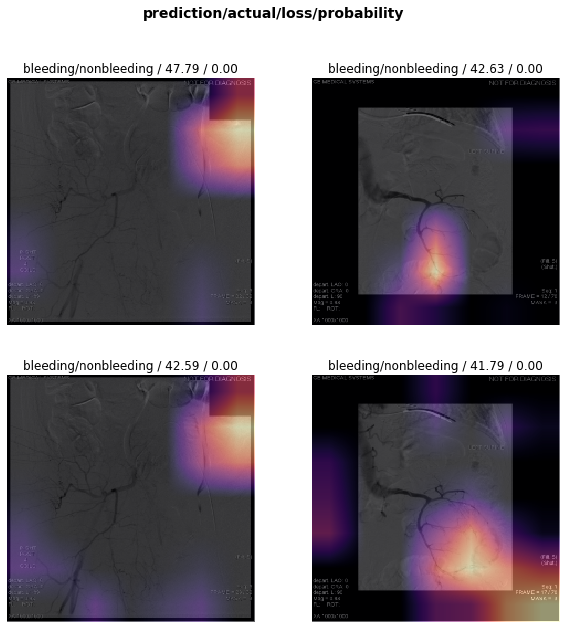

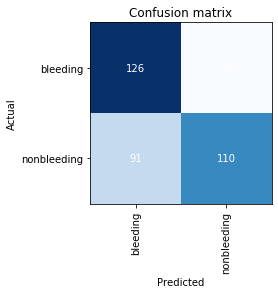

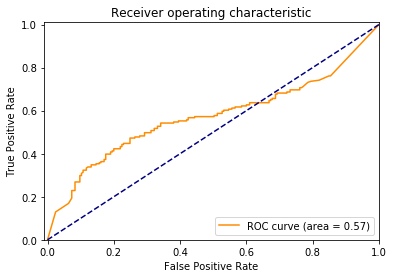

In [3]:
# Try to use the ResNet-152 model to test
# make sure we have the best performing model stage loaded
learner152 = cnn_learner(data_test, models.resnet152, metrics=accuracy)
learner152.load( "/Users/mingrenshen/Projects/MedicalImgAnalysis/resultsModelWeight/stage3/res152")
learner152.validate(data_test.valid_dl)
interp = ClassificationInterpretation.from_learner(learner152)
interp.plot_top_losses(4, figsize=(10,10))
tmpfig=interp.plot_confusion_matrix(return_fig=True)
tmpfig.savefig('confusion.png', dpi=300)

preds,y, loss = learner152.get_preds(ds_type=DatasetType.Valid,with_loss=True) #ds_type=DatasetType.Test,
# get accuracy
acc = accuracy(preds, y)
print('The accuracy is {0} %.'.format(acc))

# from fastai.vision import *
# from torchvision.models import *    # import *=all the models from torchvision  
# #interp = ClassificationInterpretation.from_learner(learner)
# plot_overview(interp, ['nonbleeding','bleeding'])
# plot_heatmap_overview(interp, ['nonbleeding','bleeding'])

from sklearn.metrics import roc_curve, auc
# probs from log preds
probs = np.exp(preds[:,1])
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y, probs, pos_label=1)

# Compute ROC area
roc_auc = auc(fpr, tpr)
print('ROC area is {0}'.format(roc_auc))
newfig=plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
newfig.savefig('roc.png', dpi=300)


In [14]:
# Generate Report of Performance
# print(len(data_test.valid_ds.items))
with open("performanceWithout1001Neg.csv",'w') as perfcsvNeg:
    with open("performanceWithout1001Pos.csv",'w') as perfPos:
        perfcsvNeg.write("%s,%s,%s,%s\n"%("IMG",'ID',"Pred","GT"))
        perfcsvPos.write("%s,%s,%s,%s\n"%("IMG",'ID',"Pred","GT"))
        for i in range(len(data_test.valid_ds.items)):
            # Bleeding
            fnames = data_test.valid_ds.items[i].name.split('.')
            if y[i].item() == 0:
                perfcsvPos.write("%s,%s,%d,%d\n"%(data_test.valid_ds.items[i].name,'a'+fnames[1].zfill(3),np.argmax(preds[i].numpy()),y[i].item()))
            if y[i].item() == 1:
                perfcsvNeg.write("%s,%s,%d,%d\n"%(data_test.valid_ds.items[i].name,'a'+fnames[1].zfill(3),np.argmax(preds[i].numpy()),y[i].item()))

NameError: name 'perfcsvPos' is not defined

In [6]:
interp.confusion_matrix()

array([[126,  79],
       [ 91, 110]])

# Take out 1023 Again

In [ ]:
from fastai.vision import *


path = Path("/Users/mingrenshen/Projects/MedicalImgAnalysis/data/DataSet10/fastAITesting2")

tfms = get_transforms(do_flip=True,
                      flip_vert=True,
                      max_lighting=0.1,
                      max_rotate=0.0, 
                      max_zoom=0.0,
                      max_warp=0.0,
                      p_affine=0.0)

# data = ImageDataBunch.from_folder(path, test='test', ds_tfms=get_transforms(), size=224)
data_test = ImageDataBunch.from_folder(path,
                                  train='train',
                                  valid='test',
                                  ds_tfms= tfms,
                                  size=224).normalize()

# Patient Level Image Classifer

In [2]:
import os 
import pandas as pd
os.getcwd()

'/Users/mingrenshen/Projects/MedicalImgAnalysis/notebooks'

In [20]:
predCSV = pd.read_csv("AnalysisPatientBased/performanceRun30.csv",header=0)

In [21]:
gtBleedingCSV = pd.read_csv("AnalysisPatientBased/bleedingInfo.csv",header=0)

In [29]:
for index, row in gtBleedingCSV.iterrows():
    gtBleedingCSV.loc[index,'JPGName'] = row['newfileName '].split('/')[-1]

In [31]:
gtBleedingCSV.head()

,imgID,patientID,label,oldfilename,newfileName,JPGName
0,1,Patient 1027,Bleeding,1027_10_15.jpg,/Users/mingrenshen/Projects/MedicalImgAnalysis...,bleeding.1.jpg
1,2,Patient 1027,Bleeding,1027_12_15.jpg,/Users/mingrenshen/Projects/MedicalImgAnalysis...,bleeding.2.jpg
2,3,Patient 1027,Bleeding,1027_9_15.jpg,/Users/mingrenshen/Projects/MedicalImgAnalysis...,bleeding.3.jpg
3,4,Patient 1027,Bleeding,1027_11_15.jpg,/Users/mingrenshen/Projects/MedicalImgAnalysis...,bleeding.4.jpg
4,5,Patient 1027,Bleeding,1027_8_15.jpg,/Users/mingrenshen/Projects/MedicalImgAnalysis...,bleeding.5.jpg


In [32]:
predCSV.head()

,IMG,ID,Pred,GT
0,bleeding.2.jpg,2,1,0
1,bleeding.70.jpg,70,1,0
2,bleeding.64.jpg,64,1,0
3,bleeding.58.jpg,58,1,0
4,bleeding.109.jpg,109,0,0


## Read the Excel File and Get the report of Bleeding Classifers

In [4]:
summaryXLSX = pd.read_excel("AnalysisPatientBased/BleedingSummary.xlsx",header=1)

In [13]:
A = summaryXLSX.groupby('patientID').sum()

In [14]:
B = summaryXLSX.groupby('patientID').count()

In [11]:
summaryXLSX.head()

,imgID,patientID,label,Pred,GT,Score,oldfilename,newfileName,IMG,ID
0,1,Patient 1027,Bleeding,1,0,False,1027_10_15.jpg,/Users/mingrenshen/Projects/MedicalImgAnalysis...,bleeding.1.jpg,a001
1,2,Patient 1027,Bleeding,1,0,False,1027_12_15.jpg,/Users/mingrenshen/Projects/MedicalImgAnalysis...,bleeding.2.jpg,a002
2,3,Patient 1027,Bleeding,1,0,False,1027_9_15.jpg,/Users/mingrenshen/Projects/MedicalImgAnalysis...,bleeding.3.jpg,a003
3,4,Patient 1027,Bleeding,1,0,False,1027_11_15.jpg,/Users/mingrenshen/Projects/MedicalImgAnalysis...,bleeding.4.jpg,a004
4,5,Patient 1027,Bleeding,0,0,True,1027_8_15.jpg,/Users/mingrenshen/Projects/MedicalImgAnalysis...,bleeding.5.jpg,a005


In [26]:
C = pd.concat([A,B['Score']], axis=1)

In [27]:
C

,imgID,Pred,GT,Score,Score
patientID,,,,,
Patient 1002,669,0,0,6.0,6
Patient 1003,936,0,0,9.0,9
Patient 1004,1295,0,0,14.0,14
Patient 1005,948,0,0,8.0,8
Patient 1006,3724,0,0,19.0,19
Patient 1009,1638,0,0,9.0,9
Patient 1010,325,0,0,10.0,10
Patient 1011,242,11,0,0.0,11
Patient 1012,2533,0,0,17.0,17


# Check Non Bleeding Patients

In [31]:
mergedCSV = pd.read_csv("AnalysisPatientBased/NonBleedingSummaryMerged.csv",header=0)

In [32]:
mergedCSV.head()

,imgID,patientID,seriesID,Pred,GT,Score,label,oldfilename,newfileName,IMG,ID
0,1,Patient 1018,Series 4,1,1,True,nonBleeding,B1018_10_25.jpg,nonbleeding.1.jpg,nonbleeding.1.jpg,a001
1,2,Patient 1018,Series 4,1,1,True,nonBleeding,B1018_9_25.jpg,nonbleeding.2.jpg,nonbleeding.2.jpg,a002
2,3,Patient 1018,Series 4,1,1,True,nonBleeding,B1018_18_25.jpg,nonbleeding.3.jpg,nonbleeding.3.jpg,a003
3,4,Patient 1018,Series 4,0,1,False,nonBleeding,B1018_14_25.jpg,nonbleeding.4.jpg,nonbleeding.4.jpg,a004
4,5,Patient 1018,Series 4,1,1,True,nonBleeding,B1018_11_25.jpg,nonbleeding.5.jpg,nonbleeding.5.jpg,a005


In [35]:
A = mergedCSV.groupby(['patientID','seriesID']).sum()

In [38]:
A

imgID  Pred  GT  Score
patientID    seriesID                          
Patient 1001 Series 1     9008     0  32    0.0
             Series 2     8910     0  36    0.0
             Series 3     6034     0  28    0.0
Patient 1008 Series 1     3465     0  18    0.0
             Series 4     1785     0  10    0.0
Patient 1013 Series 1     2490    15  15   15.0
             Series 8      626     4   4    4.0
Patient 1015 Series 1     2205     0  15    0.0
Patient 1018 Series 2      172     0   8    0.0
             Series 3      117     0   9    0.0
             Series 4       36     6   8    6.0
             Series 8      305     7  10    7.0
Patient 1020 Series 1     1972     0  17    0.0
             Series 10    1065     0  15    0.0
             Series 2      791     0  14    0.0
             Series 20     595     0  14    0.0
             Series 9     2697    29  29   29.0
Patient 1023 Sequence 1    952     0   7    0.0
             Sequence 5   1028     0   8    0.0

In [37]:
B = mergedCSV.groupby(['patientID','seriesID']).count()

In [39]:
B

imgID  Pred  GT  Score  label  oldfilename  \
patientID    seriesID                                                 
Patient 1001 Series 1       32    32  32     32     32           32   
             Series 2       36    36  36     36     36           36   
             Series 3       28    28  28     28     28           28   
Patient 1008 Series 1       18    18  18     18     18           18   
             Series 4       10    10  10     10     10           10   
Patient 1013 Series 1       15    15  15     15     15           15   
             Series 8        4     4   4      4      4            4   
Patient 1015 Series 1       15    15  15     15     15           15   
Patient 1018 Series 2        8     8   8      8      8            8   
             Series 3        9     9   9      9      9            9   
             Series 4        8     8   8      8      8            8   
             Series 8       10    10  10     10     10           10   
Patient 1020 Series 1       17    17  17     17     17           17   
             Series 10      15    15  15     15     15           15   
             Series 2       14    14  14     14     14           14   
             Series 20      14    14  14     14     14           14   
             Series 9       29    29  29     29     29           29   
Patient 1023 Sequence 1      7     7   7      7      7            7   
             Sequence 5      8     8   8      8      8            8   

                         newfileName   IMG  ID  
patientID    seriesID                           
Patient 1001 Series 1              32   32  32  
             Series 2              36   36  36  
             Series 3              28   28  28  
Patient 1008 Series 1              18   18  18  
             Series 4              10   10  10  
Patient 1013 Series 1              15   15  15  
             Series 8               4    4   4  
Patient 1015 Series 1              15   15  15  
Patient 1018 Series 2               8    8   8  
             Series 3               9    9   9  
             Series 4               8    8   8  
             Series 8              10   10  10  
Patient 1020 Series 1              17   17  17  
             Series 10             15   15  15  
             Series 2              14   14  14  
             Series 20             14   14  14  
             Series 9              29   29  29  
Patient 1023 Sequence 1             7    7   7  
             Sequence 5             8    8   8

In [40]:
C = pd.concat([A,B['Score']], axis=1)

In [41]:
C

imgID  Pred  GT  Score  Score
patientID    seriesID                                 
Patient 1001 Series 1     9008     0  32    0.0     32
             Series 2     8910     0  36    0.0     36
             Series 3     6034     0  28    0.0     28
Patient 1008 Series 1     3465     0  18    0.0     18
             Series 4     1785     0  10    0.0     10
Patient 1013 Series 1     2490    15  15   15.0     15
             Series 8      626     4   4    4.0      4
Patient 1015 Series 1     2205     0  15    0.0     15
Patient 1018 Series 2      172     0   8    0.0      8
             Series 3      117     0   9    0.0      9
             Series 4       36     6   8    6.0      8
             Series 8      305     7  10    7.0     10
Patient 1020 Series 1     1972     0  17    0.0     17
             Series 10    1065     0  15    0.0     15
             Series 2      791     0  14    0.0     14
             Series 20     595     0  14    0.0     14
             Series 9     2697    29  29   29.0     29
Patient 1023 Sequence 1    952     0   7    0.0      7
             Sequence 5   1028     0   8    0.0      8